In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import sys

In [5]:
sys.executable

'/home/nicolasf/anaconda3/envs/pangeo/bin/python'

In [6]:
import pathlib 
import os 

In [7]:
import numpy as np 
import pandas as pd
import xarray as xr
import regionmask

In [8]:
import geopandas as gpd

### path definitions 

In [9]:
CWD = pathlib.Path.cwd()

In [10]:
HOME = pathlib.Path.home() 

### import local functions 

In [11]:
sys.path.insert(0, str(HOME.joinpath('research/Smart_Ideas/code/ml4seas'))) 

In [12]:
import utils

### define local functions 

In [13]:
domain = [120, 220, -60, -10]

In [14]:
def extract(dset,domain=domain): 
    dset = dset.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])) 
    return dset

In [15]:
def make_mask(dset, shape, buffer=0.25):
    if buffer is not None: 
        shape = shape.buffer(buffer)
    mask = regionmask.mask_geopandas(shape, dset.lon.data, dset_era.lat.data)
    mask = mask.where(np.isnan(mask), 9999)
    mask = mask.where(mask==9999, 1)
    mask = mask.where(mask==1, np.nan)
    return mask 

### parameters 

In [16]:
period  = 'hindcasts'

In [17]:
provider = 'CDS'

In [18]:
GCM = 'ECMWF'

In [19]:
reanalysis = 'ERA5'

In [20]:
varname = 'T2M'

### paths definitions 

In [21]:
root_path_gcm = pathlib.Path('/media/nicolasf/END19101/data/GCMs/processed/')

In [22]:
dpath_gcm = root_path_gcm.joinpath(f'{period}/{provider}/{GCM}/{varname}/')

In [23]:
root_path_era5 = pathlib.Path(f'/media/nicolasf/END19101/data/REANALYSIS/processed/{reanalysis}/')

In [24]:
dpath_era5 = root_path_era5.joinpath(varname)

### list the files (GCM and ERA5)

In [25]:
lfiles_GCM = utils.list_files(dpath_gcm, pattern="ECMWF_T2M", extension=".nc", include="seasonal_anomalies", exclude="interp")

In [26]:
lfiles_ERA = utils.list_files(dpath_era5, pattern="ERA", extension=".nc", include="seasonal", exclude="monthly") 

### read and extract the GCM data 

In [27]:
dset_gcm = xr.open_mfdataset(lfiles_GCM, parallel=True, concat_dim='time', combine='nested')

In [28]:
dset_gcm = extract(dset_gcm)

#### select the 3 months leadtime 

In [29]:
dset_gcm = dset_gcm.sel(step=3)

### read, extract, and data munging on the ERA5 dataset 

In [30]:
dset_era = xr.open_mfdataset(lfiles_ERA, concat_dim='time', combine='nested', parallel=True)

In [31]:
dset_era = dset_era.rename({'latitude':'lat','longitude':'lon'})

In [32]:
dset_era = dset_era.sortby('lat')

In [33]:
dset_era = extract(dset_era)

In [34]:
dset_era

,Array,Chunk
Bytes,146.37 MB,322.40 kB
Shape,"(454, 201, 401)","(1, 201, 401)"
Count,2724 Tasks,454 Chunks
Type,float32,numpy.ndarray


In [35]:
dset_era = dset_era.sel(time=slice('1993','2016'))

### get the ERA5 grid 

In [36]:
era_grid = dset_era[['lat','lon']]

In [37]:
dset_gcm_interp = dset_gcm.interp_like(era_grid)

In [38]:
dset_gcm_interp

,Array,Chunk
Bytes,2.30 kB,8 B
Shape,"(288,)","(1,)"
Count,1436 Tasks,288 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,2.32 GB,8.06 MB
Shape,"(288, 25, 201, 401)","(1, 25, 201, 401)"
Count,2880 Tasks,288 Chunks
Type,float32,numpy.ndarray


### read the shapefiles 

In [39]:
shapes_filename = '/media/nicolasf/END19101/data/shapefiles/NZ_regions/NZ_6_regions/NZ_regions_corrected.shp'

In [40]:
shapes = gpd.read_file(shapes_filename)
# shapes = gpd.read_file('/home/nicolasf/data/shapefiles/NZ/coastlines/NZ.shp') 

In [41]:
shapes.head()

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."


In [42]:
shapes.loc[:,'all'] = 1

In [43]:
shape = shapes.dissolve(by='all')

<AxesSubplot:>

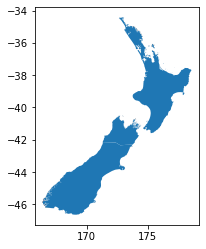

In [44]:
shape.plot()

### change the coordinate reference system to lat and lon 

In [45]:
shape = shape.to_crs('EPSG:4326')

### make the mask

In [46]:
mask_in = make_mask(era_grid, shape)

<ipython-input-15-e3379ffdfb09>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shape = shape.buffer(buffer)


In [47]:
mask_out = make_mask(era_grid, shape, buffer=1)

<ipython-input-15-e3379ffdfb09>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shape = shape.buffer(buffer)


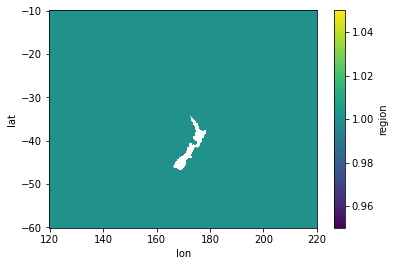

In [48]:
mask_in.plot()

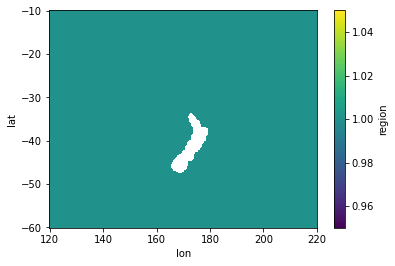

In [49]:
mask_out.plot()

In [50]:
mask_out.to_netcdf('./mask_out.nc')

In [51]:
mask_in.to_netcdf('./mask_in.nc')

In [52]:
dset_gcm_interp

,Array,Chunk
Bytes,2.30 kB,8 B
Shape,"(288,)","(1,)"
Count,1436 Tasks,288 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,2.32 GB,8.06 MB
Shape,"(288, 25, 201, 401)","(1, 25, 201, 401)"
Count,2880 Tasks,288 Chunks
Type,float32,numpy.ndarray


In [53]:
opath = pathlib.Path(f'reg_interp_{GCM}_{varname}') 

In [54]:
if not opath.exists(): 
    opath.mkdir(parents=True)

In [55]:
dset_gcm_interp['mask_out'] = (('lat','lon'), mask_out) 

In [56]:
dset_gcm_interp['mask_in'] = (('lat','lon'), mask_in) 

In [57]:
dset_gcm_interp

,Array,Chunk
Bytes,2.30 kB,8 B
Shape,"(288,)","(1,)"
Count,1436 Tasks,288 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,2.32 GB,8.06 MB
Shape,"(288, 25, 201, 401)","(1, 25, 201, 401)"
Count,2880 Tasks,288 Chunks
Type,float32,numpy.ndarray


In [58]:
for t in dset_gcm_interp.time:
    date = pd.to_datetime(t.data)
    sub = dset_gcm_interp.sel(time=t)
    sub.to_netcdf(opath.joinpath(f"reg_interp_{GCM}_{varname}_{date:%Y-%m}.nc"))
    sub.close() 

In [59]:
opath = pathlib.Path(f'reg_interp_ERA5_{varname}') 

In [60]:
if not opath.exists(): 
    opath.mkdir(parents=True)

In [61]:
dset_era

,Array,Chunk
Bytes,92.85 MB,322.40 kB
Shape,"(288, 201, 401)","(1, 201, 401)"
Count,3012 Tasks,288 Chunks
Type,float32,numpy.ndarray


In [62]:
for t in dset_era.time:
    date = pd.to_datetime(t.data)
    sub = dset_era.sel(time=t)
    sub.to_netcdf(opath.joinpath(f"reg_ERA5_{varname}_{date:%Y-%m}.nc"))
    sub.close() 

In [63]:
dset_gcm_interp

,Array,Chunk
Bytes,2.30 kB,8 B
Shape,"(288,)","(1,)"
Count,1436 Tasks,288 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,2.32 GB,8.06 MB
Shape,"(288, 25, 201, 401)","(1, 25, 201, 401)"
Count,2880 Tasks,288 Chunks
Type,float32,numpy.ndarray


In [64]:
dset_gcm_interp['t2m_mask_in'] = dset_gcm_interp['t2m'] * dset_gcm_interp['mask_in']

In [65]:
ess = dset_gcm_interp['t2m_mask_in'][0,0,:,:]

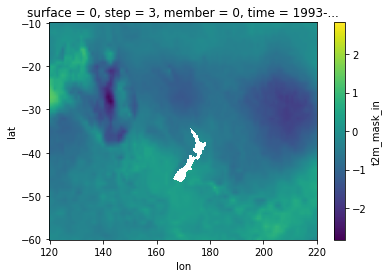

In [66]:
ess.plot(cmap='viridis')

In [72]:
dset_era

,Array,Chunk
Bytes,92.85 MB,322.40 kB
Shape,"(288, 201, 401)","(1, 201, 401)"
Count,3012 Tasks,288 Chunks
Type,float32,numpy.ndarray


In [67]:
era = dset_era['t2m'][3,:,:]

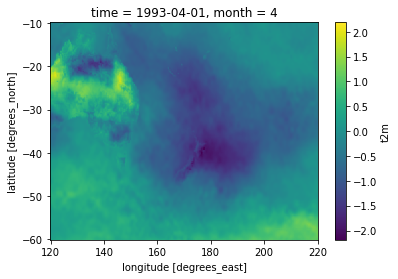

In [68]:
era.plot(cmap='viridis')

### assign values inside mask 

In [69]:
ess2 = ess.where(~np.isnan(ess), era)

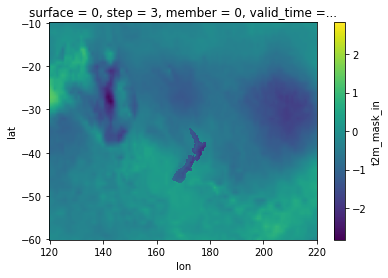

In [70]:
ess2.plot(cmap='viridis')

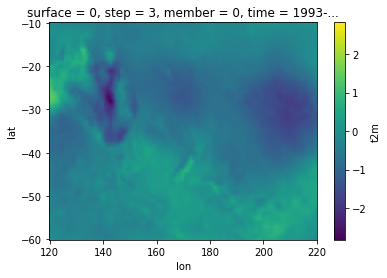

In [71]:
dset_gcm_interp['t2m'][0,0,:,:].plot(cmap='viridis')

In [ ]:
dset_gcm_interp.time